# Import Modules & Util Functions

In [7]:
import os
import sys
import glob
import re
import ast
import warnings

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from my_utils import *

# Configure display options
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

# Single Radio Evaluation

In [32]:
class Eval:
    def __init__(self, filepaths, model_name='Trial',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_name
        with open(f'../models/{model_name}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'../models/{model_name}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'../models/{model_name}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'../models/{model_name}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []

        # Standard deviations for error bars
        self.LOSS_STD = []
        
        self.DEVICES = []
        self.TRACES = []
        
        # all records
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not Eval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = prob_model['Stable']
        random_bool_array = [Eval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(Eval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        return answer, eval_value, ground_value
    
    
    def hist_method_all(self, N=3):
        n = len(self.filepaths)
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(self.filepaths):
                
                # if i > 0:
                #     break
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                
                print(f'{i+1}/{n}', filepath[0]); print(f'{i+1}/{n}', filepath[1])
                
                if ho_df.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                loss_rate_list = []
                for iter_round in tqdm(range(N), ncols=1000):
                    _, eval_value, ground_value = eval.hist_method(df, ho_df, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    loss_rate_list.append(eval_value)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                print()
                print("Mean:", mean_value)
                print("Standard Deviation:", std_deviation)
                print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                error = mean_value - ground_value
                path = filepath[1]
                
                self.records.append((mean_value, std_deviation, ground_value, error, path))

                # 找到 "sm" 的位置
                sm_index = path.index("sm")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.DEVICES.append(sm_label)
                
                # 找到 "sm" 的位置
                sm_index = path.index("#")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.TRACES.append(sm_label)
    
    
    def plot(self, save_path='./plot.png'):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        # mse = mean_squared_error(y, y_pred)
        mse = np.sqrt(mean_squared_error(x, y))
        mse_rate = mse / np.mean(x) * 100
        slope_annotation = f'RMSE: {mse:.3f} ({mse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 1.1 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 0.9 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        
        # 获取 x 的边界
        x_limits = ax.get_xlim()

        # 创建 x 值范围
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values

        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')

        # 在两条线之间填充颜色
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        if not os.path.isdir(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        fig.savefig(save_path, dpi=300)

        # Show the plot
        plt.show()
    
    
    def calculate_mse(self):
        arr = np.array([item[3] for item in self.records])
        # Calculate RMS
        rms = np.sqrt(np.mean(arr**2))
        return rms
        

# BR Eval

In [33]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

print(len(filepaths))
pprint(filepaths)

54
[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2

0/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
0/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …


Mean: 0.472901297668439
Standard Deviation: 0.02061027156143223
Ground Truth: 0.47852155675062485


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_97035/1214052124.py:3: RankWarning: Polyfit may be poorly conditioned
  eval.plot('./figures/BR.png')


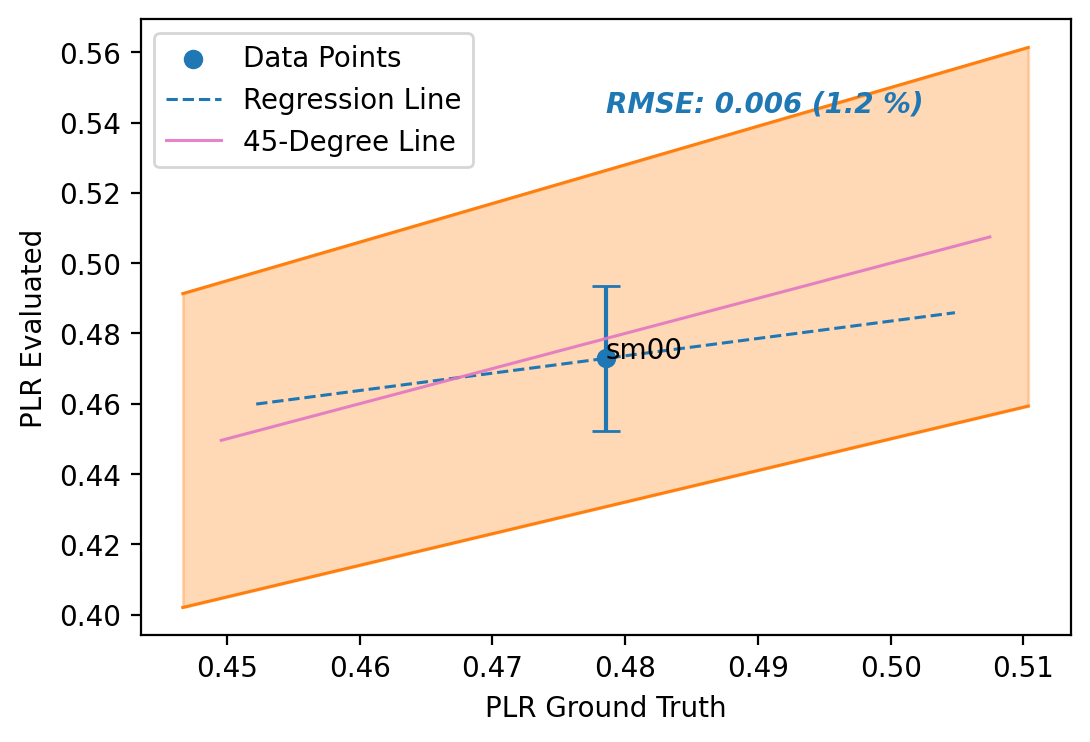

In [34]:
eval = Eval(filepaths, model_name='BR')
eval.hist_method_all()
eval.plot('./figures/BR.png')

# A Eval

In [23]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8882208139198076
Standard Deviation: 0.05425633741245463
Ground Truth: 1.6379561519907104


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.2424443925927258
Standard Deviation: 0.07500925369618781
Ground Truth: 2.3746092958736003


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.1797479460796043
Standard Deviation: 0.04101682406798107
Ground Truth: 2.217037568796363
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 1.2648037271394155
Standard Deviation: 0.032933457242587526
Ground Truth: 0.9734397834195736


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.337270742378743
Standard Deviation: 0.11529370611528748
Ground Truth: 2.744135292163575


  0%|                                                                                                         …


Mean: 2.4057269687164933
Standard Deviation: 0.19723278800272656
Ground Truth: 2.562141346596212


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.6322174289376121
Standard Deviation: 0.10019764340902107
Ground Truth: 1.3897898624867375


  0%|                                                                                                         …


Mean: 1.6244278949668434
Standard Deviation: 0.11555597154145682
Ground Truth: 0.44073382138529044


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.040284941024604
Standard Deviation: 0.14136397247278681
Ground Truth: 1.5684648077140004


  0%|                                                                                                         …


Mean: 2.0958196243491316
Standard Deviation: 0.10250002771757755
Ground Truth: 1.8816136585944214


  0%|                                                                                                         …


Mean: 1.7337401539396307
Standard Deviation: 0.3634222120444903
Ground Truth: 2.0673710717207765


  0%|                                                                                                         …


Mean: 1.7908883711271966
Standard Deviation: 0.02134858041645214
Ground Truth: 6.382264672485946


  0%|                                                                                                         …


Mean: 1.4299171843648246
Standard Deviation: 0.11711834272839798
Ground Truth: 1.0299646232896194


  0%|                                                                                                         …


Mean: 2.3303880027566617
Standard Deviation: 0.01596140621992792
Ground Truth: 2.299205232416455


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8819621327349474
Standard Deviation: 0.05207061797280019
Ground Truth: 1.8903402284197095


  0%|                                                                                                         …


Mean: 1.6193552804151272
Standard Deviation: 0.05934446232399365
Ground Truth: 1.738552651131886


  0%|                                                                                                         …


Mean: 1.7244625716220652
Standard Deviation: 0.14645431351255964
Ground Truth: 0.44681836697880156


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.316708880975806
Standard Deviation: 0.05530304063494105
Ground Truth: 2.74148794391893


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.542443906172073
Standard Deviation: 0.09419720455959492
Ground Truth: 2.2319373821002606


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7933864333984708
Standard Deviation: 0.08905548093126185
Ground Truth: 1.3810003620166706


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.5162472340396382
Standard Deviation: 0.08291128297217526
Ground Truth: 3.6874833014776907


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.2901753243263439
Standard Deviation: 0.06595577047010436
Ground Truth: 0.603484989314558


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.6740099423242432
Standard Deviation: 0.036499909069313496
Ground Truth: 0.9581369060617348


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8764130164322115
Standard Deviation: 0.0761916113585895
Ground Truth: 1.578252898196007


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.5682374737577829
Standard Deviation: 0.011225361003593153
Ground Truth: 0.9718292849011854


  0%|                                                                                                         …


Mean: 1.3669740190363633
Standard Deviation: 0.03501144296119629
Ground Truth: 0.5094277208071452


  0%|                                                                                                         …


Mean: 1.7266577413118502
Standard Deviation: 0.008451239446426326
Ground Truth: 1.4311977197974024


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7026895178921013
Standard Deviation: 0.051503953943344324
Ground Truth: 1.236207614067443


  0%|                                                                                                         …


Mean: 1.6464970462299167
Standard Deviation: 0.06769347856844635
Ground Truth: 1.1670469550787477


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.4178516181986123
Standard Deviation: 0.05747581285837866
Ground Truth: 3.495177440707094


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.3816108346507845
Standard Deviation: 0.08139202632423158
Ground Truth: 0.7262687498889788


  0%|                                                                                                         …


Mean: 1.708076908580874
Standard Deviation: 0.07331964150042905
Ground Truth: 1.166938571128592


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.751281102512447
Standard Deviation: 0.1310436859819943
Ground Truth: 1.2368160557117511


  0%|                                                                                                         …


Mean: 1.5099476011566235
Standard Deviation: 0.06649578041477858
Ground Truth: 0.7457934102293791


  0%|                                                                                                         …


Mean: 1.3444118061300996
Standard Deviation: 0.23528094299286034
Ground Truth: 0.4749001242280027


  0%|                                                                                                         …


Mean: 1.3223073211466096
Standard Deviation: 0.08756770755868445
Ground Truth: 0.622930101864757


  0%|                                                                                                         …


Mean: 1.1347805550323915
Standard Deviation: 0.04355986112907982
Ground Truth: 0.6658012035766495


  0%|                                                                                                         …


Mean: 1.0656755353331666
Standard Deviation: 0.051687945561295696
Ground Truth: 0.5200523529088501


  0%|                                                                                                         …


Mean: 1.086418978964722
Standard Deviation: 0.13263354108862088
Ground Truth: 0.6217759300045796
******** Empty RRC Data ********
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 0.9485866059571239
Standard Deviation: 0.3540842448864829
Ground Truth: 0.04580979219012452
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 0.9116709300645537
Standard Deviation: 0.09543785900036898
Ground Truth: 0.19763600388983588


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.23048502524216
Standard Deviation: 0.06677627581832056
Ground Truth: 2.760555124931417


  0%|                                                                                                         …


Mean: 2.4198975274670365
Standard Deviation: 0.1897821158017852
Ground Truth: 3.552642099021247


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.3147623837788984
Standard Deviation: 0.03293734565648668
Ground Truth: 3.401611495646497


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.121055512233797
Standard Deviation: 0.017540780441616922
Ground Truth: 6.178330114022685


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7348516893876063
St

  0%|                                                                                                         …


Mean: 1.9222570341614693
Standard Deviation: 0.12687087857321272
Ground Truth: 2.9138841386541507


  0%|                                                                                                         …


Mean: 2.4519240550457404
Standard Deviation: 0.10812747621781996
Ground Truth: 2.531956694946149


  0%|                                                                                                         …


Mean: 1.5912913865825589
Standard Deviation: 0.15887350176334258
Ground Truth: 1.4710818277294302


  0%|                                                                                                         …


Mean: 1.8441259598309196
Standard Deviation: 0.17298517277211922
Ground Truth: 3.251294364823291


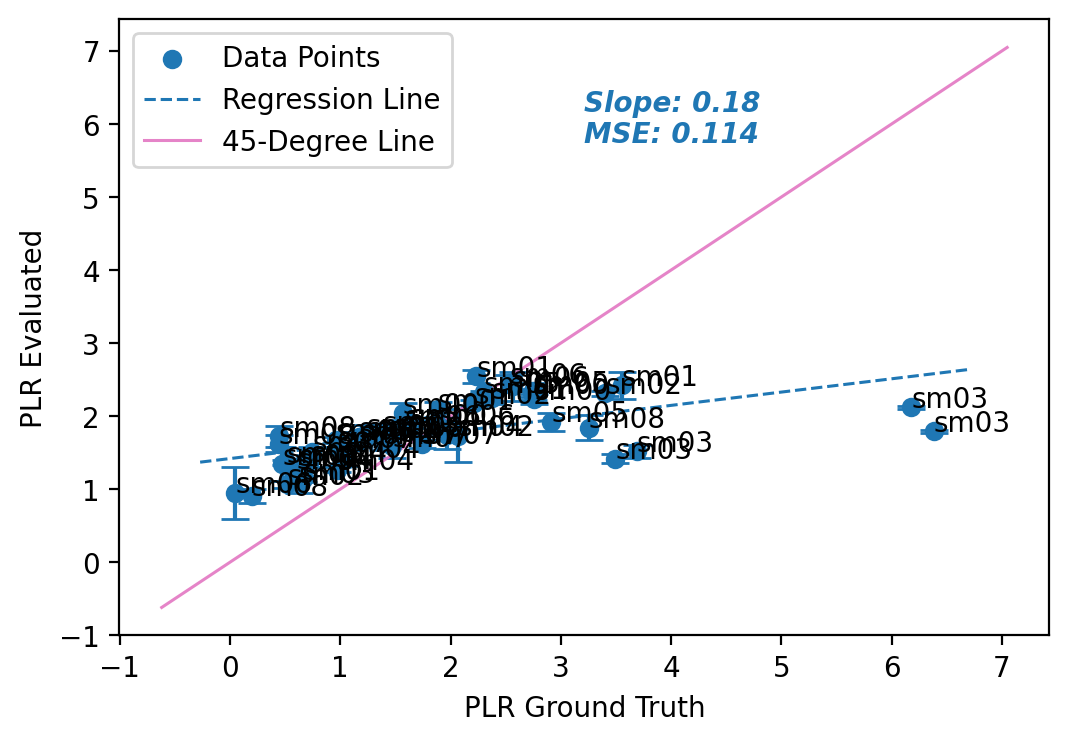

In [24]:
eval = Eval(filepaths, model_name='A')
eval.hist_method_all()
eval.plot('./figures/A.png')